In [1]:
# ---------------------------------------------------------
# CELL 1: Imports & Environment Setup
# Description: Import all necessary libraries and do basic checks.
# ---------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Optional: Check if GPU is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("✅ Libraries imported and environment ready!")


Num GPUs Available: 1
✅ Libraries imported and environment ready!


In [6]:
# -------- CELL 1: IMPORT LIBRARIES --------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [7]:
# ---------------------------------------------------------
# CELL 2: Load CSV Metadata
# Description: Read the RSNA CSVs and prepare 'labels_simple' with "Normal"/"Pneumonia".
# ---------------------------------------------------------
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"  # Adjust if needed
labels_path = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_path = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Load labels and class info
labels_df = pd.read_csv(labels_path)
class_info_df = pd.read_csv(class_info_path)

# Merge dataframes
merged_df = pd.merge(labels_df, class_info_df, on='patientId')

# Simplify labels
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})

# Append ".dcm" to match actual filenames
labels_simple["patientId"] = labels_simple["patientId"].astype(str) + ".dcm"

print("Sample of labels_simple:")
print(labels_simple.head())
print(f"✅ Dataset loaded and preprocessed! Total rows: {len(labels_simple)}")


Sample of labels_simple:
                                  patientId     Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm     Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm     Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb.dcm     Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm     Normal
4  00436515-870c-4b36-a041-de91049b9ab4.dcm  Pneumonia
✅ Dataset loaded and preprocessed! Total rows: 26684


In [8]:
# ---------------------------------------------------------
# CELL 3: Create TFRecords from DICOMs
# Description: Convert each DICOM to 128x128, normalize, stack to 3 channels, then write to a TFRecord file.
# ---------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

tfrecord_path = "/kaggle/working/pneumonia_data.tfrecords"  # Output path for the TFRecords

def serialize_example(image, label):
    """
    Converts image array & label to a tf.train.Example for TFRecord.
    """
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

with tf.io.TFRecordWriter(tfrecord_path) as writer:
    for idx, row in labels_simple.iterrows():
        # Build the full path to the DICOM image
        dicom_path = os.path.join(dataset_path, "stage_2_train_images", row['patientId'])
        dicom = pydicom.dcmread(dicom_path)
        
        # Convert the DICOM pixel data to float32 and resize to 128x128
        img = dicom.pixel_array.astype(np.float32)
        img = cv2.resize(img, (128, 128))
        
        # Normalize the image to the range [0, 1]
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)
        
        # Convert a single channel image to 3 channels by stacking
        img = np.stack([img] * 3, axis=-1)
        
        # Encode the label: 1 for Pneumonia, 0 for Normal
        label = 1 if row['Target'] == 'Pneumonia' else 0
        
        # Serialize the example and write to TFRecord
        example = serialize_example(img, label)
        writer.write(example)

print(f"✅ TFRecords created at: {tfrecord_path}")


✅ TFRecords created at: /kaggle/working/pneumonia_data.tfrecords


In [9]:
# ---------------------------------------------------------
# CELL 4: Random Noise Masking & Data Augmentation
# Description: Define a function to randomly mask a portion of the image with noise and set up data augmentation layers.
# ---------------------------------------------------------
import random
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

def random_noise_mask(image):
    """
    Randomly replaces a portion of the image with noise to prevent reliance on spurious corner artifacts.
    """
    def _random_noise_np(img_np):
        h, w, c = img_np.shape
        # Randomly choose a mask size (between 1/5 and 1/3 of the image height)
        mask_size = random.randint(h // 5, h // 3)
        # Randomly select top-left corner of the mask
        x1 = random.randint(0, w - mask_size)
        y1 = random.randint(0, h - mask_size)
        # Fill the region with random noise (values between 0 and 255)
        noise = np.random.randint(0, 256, (mask_size, mask_size, c)).astype(np.float32)
        img_np[y1:y1+mask_size, x1:x1+mask_size, :] = noise
        return img_np

    # Apply the numpy function and set the shape back
    image = tf.numpy_function(_random_noise_np, [image], tf.float32)
    image.set_shape((128, 128, 3))
    return image

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

print("✅ Random noise masking & data augmentation defined!")


✅ Random noise masking & data augmentation defined!


In [10]:
# ---------------------------------------------------------
# CELL 5: Build TF.Data Pipeline
# Description: Parse TFRecords, apply random noise & augmentation, then split train/val.
# ---------------------------------------------------------
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    label = example['label']
    
    # Reshape to 128x128x3
    image = tf.reshape(image, (128, 128, 3))
    
    # Apply random noise
    image = random_noise_mask(image)
    
    # Apply data augmentation
    image = data_augmentation(image)
    
    return image, label

dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

# Split into train/validation
train_size = int(0.8 * len(labels_simple))  # 80% for training
train_data = dataset.take(train_size).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

print("✅ Train/validation datasets created with random noise + augmentation!")


✅ Train/validation datasets created with random noise + augmentation!


In [11]:
# ---------------------------------------------------------
# CELL 6: Define & Compile Model
# Description: Using ResNet50 as an example. Swap with EfficientNet if you prefer.
# ---------------------------------------------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Transfer learning: freeze base

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output)
    
    # For ResNet50, a typical last conv layer is "conv5_block3_out"
    global last_conv_layer_name
    last_conv_layer_name = "conv5_block3_out"

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

trained_model = build_model()
trained_model.summary()
print(f"✅ Model built. Using last conv layer: {last_conv_layer_name}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

✅ Model built. Using last conv layer: conv5_block3_out


In [12]:
# ---------------------------------------------------------
# CELL 7: Train the Model
# Description: Fit the model on our updated train/val datasets with random noise & augmentation.
# ---------------------------------------------------------
epochs = 5  # Adjust as needed

history = trained_model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

print("✅ Model training complete!")


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 108s 142ms/step - accuracy: 0.7064 - loss: 0.6014 - val_accuracy: 0.8156 - val_loss: 0.4779
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 85s 126ms/step - accuracy: 0.7375 - loss: 0.5614 - val_accuracy: 0.8156 - val_loss: 0.4871
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 86s 126ms/step - accuracy: 0.7409 - loss: 0.5635 - val_accuracy: 0.8156 - val_loss: 0.4783
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 86s 126ms/step - accuracy: 0.7386 - loss: 0.5581 - val_accuracy: 0.8156 - val_loss: 0.4813
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 86s 126ms/step - accuracy: 0.7411 - loss: 0.5580 - val_accuracy: 0.8156 - val_loss: 0.4758
✅ Model training complete!


In [14]:
# ---------------------------------------------------------
# CELL 8: Grad-CAM Utilities
# Description: Define functions for computing and displaying Grad-CAM heatmaps.
# ---------------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for the top predicted class (or specified class).
    """
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # top predicted class
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    grads = tf.abs(grads)  # Optionally take absolute value
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-10)
    return heatmap

def display_gradcam(img_path, model, last_conv_layer_name, alpha=0.4):
    """
    Loads an image, computes its Grad-CAM heatmap, and overlays the heatmap on the image.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image using OpenCV for overlay
    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (128, 128))
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Resize heatmap and apply colormap
    heatmap = cv2.resize(heatmap, (128, 128))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(orig, 1 - alpha, heatmap, alpha, 0)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()

print("✅ Grad-CAM utilities defined!")


✅ Grad-CAM utilities defined!


✅ Sample image saved as sample_image.jpg, label: 0


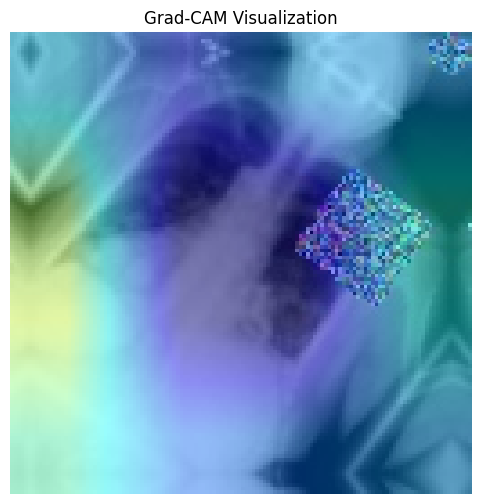

In [15]:
# ---------------------------------------------------------
# CELL 9: Test Grad-CAM
# Description: Extract one sample image, save it, and display the Grad-CAM heatmap.
# ---------------------------------------------------------
sample_dataset = dataset.take(1)
for img, label in sample_dataset:
    sample_img = img.numpy()
    sample_label = label.numpy()
    break

# Convert the image back to [0, 255] and save it
sample_img = (sample_img * 255).astype(np.uint8)
sample_img_path = "sample_image.jpg"
cv2.imwrite(sample_img_path, sample_img)
print(f"✅ Sample image saved as {sample_img_path}, label: {sample_label}")

# Display Grad-CAM for the sample image
display_gradcam(sample_img_path, trained_model, last_conv_layer_name, alpha=0.4)


# Debugging

In [16]:
# ---------------------------------------------------------
# CELL 1: No-Augment Parse Function
# Description: Parses TFRecords without random noise or data augmentation.
#              This helps us see the raw image that the model expects.
# ---------------------------------------------------------
def parse_tfrecord_no_augment(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    image = tf.io.decode_raw(example['image'], tf.float32)
    label = example['label']

    # Reshape to 128x128x3
    image = tf.reshape(image, (128, 128, 3))
    
    return image, label

# Create a "no-augment" dataset
no_aug_dataset = tf.data.TFRecordDataset(tfrecord_path)
no_aug_dataset = no_aug_dataset.map(parse_tfrecord_no_augment, num_parallel_calls=tf.data.AUTOTUNE)
no_aug_dataset = no_aug_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

print("✅ No-augment, no-noise dataset created for debugging!")


✅ No-augment, no-noise dataset created for debugging!


Label for this sample: [0]
Image shape: (1, 128, 128, 3), dtype: float32


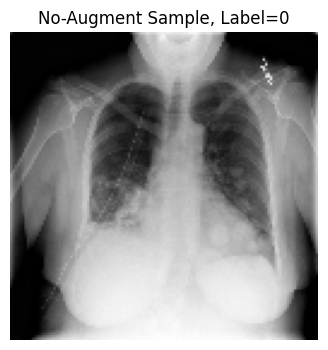

In [17]:
# ---------------------------------------------------------
# CELL 2: Inspect One Sample (No-Augment)
# Description: Retrieve one raw image & label, visualize it to confirm it's correct.
# ---------------------------------------------------------
import matplotlib.pyplot as plt

sample_no_aug = no_aug_dataset.take(1)
for img, lbl in sample_no_aug:
    raw_img = img.numpy()
    raw_label = lbl.numpy()
    break

print(f"Label for this sample: {raw_label}")
print(f"Image shape: {raw_img.shape}, dtype: {raw_img.dtype}")

# Convert to displayable format
display_img = (raw_img[0] * 255).astype(np.uint8)  # raw_img is shape (1,128,128,3)
plt.figure(figsize=(4,4))
plt.imshow(display_img)
plt.title(f"No-Augment Sample, Label={raw_label[0]}")
plt.axis("off")
plt.show()


Label for this sample: [0]
Augmented image shape: (1, 128, 128, 3), dtype: float32


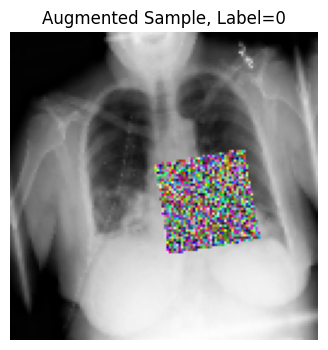

In [18]:
# ---------------------------------------------------------
# CELL 3: Inspect One Sample (Augmented)
# Description: Compare how the image looks after random noise & augmentation.
# ---------------------------------------------------------
aug_dataset = tf.data.TFRecordDataset(tfrecord_path)
def parse_tfrecord_with_noise_aug(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    label = example['label']

    image = tf.reshape(image, (128, 128, 3))

    # Apply random noise
    image = random_noise_mask(image)
    # Apply data augmentation
    image = data_augmentation(image)
    return image, label

aug_dataset = aug_dataset.map(parse_tfrecord_with_noise_aug, num_parallel_calls=tf.data.AUTOTUNE)
aug_dataset = aug_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

sample_aug = aug_dataset.take(1)
for img, lbl in sample_aug:
    aug_img = img.numpy()
    aug_label = lbl.numpy()
    break

print(f"Label for this sample: {aug_label}")
print(f"Augmented image shape: {aug_img.shape}, dtype: {aug_img.dtype}")

# Convert to displayable format
display_aug_img = (aug_img[0] * 255).astype(np.uint8)  # shape (1,128,128,3)
plt.figure(figsize=(4,4))
plt.imshow(display_aug_img)
plt.title(f"Augmented Sample, Label={aug_label[0]}")
plt.axis("off")
plt.show()


In [19]:
# ---------------------------------------------------------
# CELL 4: Model Predictions
# Description: Run a forward pass on the no-augment sample and the augmented sample.
#              Ensure the model returns a sensible probability.
# ---------------------------------------------------------
# Let's assume 'trained_model' is already defined & loaded from your previous code.

# 1) No-Augment Sample
pred_no_aug = trained_model.predict(raw_img)  # raw_img is shape (1,128,128,3)
print(f"No-Augment Prediction: {pred_no_aug[0][0]:.4f} (label={raw_label[0]})")

# 2) Augmented Sample
pred_aug = trained_model.predict(aug_img)  # aug_img is shape (1,128,128,3)
print(f"Augmented Prediction: {pred_aug[0][0]:.4f} (label={aug_label[0]})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
No-Augment Prediction: 0.2362 (label=0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Augmented Prediction: 0.1360 (label=0)


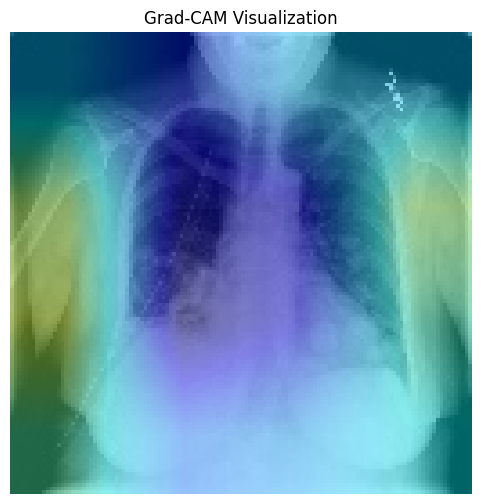

In [20]:
# ---------------------------------------------------------
# CELL 5: Grad-CAM on No-Augment Sample
# Description: Generate a Grad-CAM heatmap on the clean sample.
# ---------------------------------------------------------
# We'll use your existing display_gradcam function, but we need an actual image file.

# 1) Save the no-augment image to disk
sample_no_aug_path = "sample_no_aug.jpg"
cv2.imwrite(sample_no_aug_path, (raw_img[0]*255).astype(np.uint8))

# 2) Run Grad-CAM
display_gradcam(sample_no_aug_path, trained_model, last_conv_layer_name, alpha=0.4)


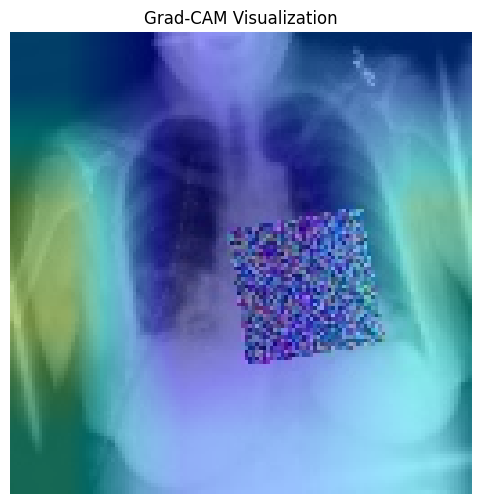

In [21]:
# ---------------------------------------------------------
# CELL 6: Grad-CAM on Augmented Sample
# Description: Compare the swirl effect when noise & augmentation are applied.
# ---------------------------------------------------------
sample_aug_path = "sample_aug.jpg"
cv2.imwrite(sample_aug_path, (aug_img[0]*255).astype(np.uint8))

display_gradcam(sample_aug_path, trained_model, last_conv_layer_name, alpha=0.4)


impmement these fixes
Summary of Fixes
Shallower Layer: Switch last_conv_layer_name to a mid-depth layer like "conv4_block6_out" for better spatial resolution.

No Absolute Gradients: Remove tf.abs(grads) so the sign of gradients matters.

Fine-Tune: Unfreeze some layers if possible, so the model truly learns pneumonia features at 128×128.

Separate Inference Pipeline: Don’t visualize Grad-CAM on the random noise. Instead, do it on the original image to see true lung activation.

Following these steps, you should see a less swirl-like and more localized Grad-CAM focusing on the